In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")
import os, sys
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"
sys.path.append("../scripts/")
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pickle
from jax import jit, vmap, value_and_grad
import jax.numpy as jnp
import jaxley as jx

from network import initialize_RNN as initialise_DMS_RNN
from parameterisation import ParamTransform

from DMS_utils import DMS

from sklearn.decomposition import PCA
import scipy.ndimage as ndimage
import scipy.signal as signal

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Main Figure

In [2]:
# Load model
fname  = "../results/dms_mods_DMS_18000_22000_2024_08_11_T_02_56_32"
params = pickle.load(open(fname +"_params.p", "rb" ))
init_params = pickle.load(open(fname +"_initparams.p", "rb" ))
dms_config = pickle.load(open(fname +"_config.p", "rb" ))
dt = 0.025

# Make delay period deterministic for plots
dms_config['delay'][1]-=int(50/dt)
dms_config['delay'][0]=dms_config['delay'][1]-1
task_params = dms_config
training_params = dms_config
RNN_params = dms_config
_ = np.random.seed(RNN_params['seed'])

network, init_conn_matrix, init_input_weights=initialise_DMS_RNN(RNN_params)
#dms_config_old = dms_config.copy()

2.58
129
50
conn probability recurrence: 0.0516
EIratio:4.0
Normaliser: 0.5084204281372233
Spectral radius recurrence: 0.0032031662162522252


In [3]:
#for el in dms_config.keys():
#    print(el, dms_config[el], dms_config_old[el])

In [4]:
# initialize with trained parameters

network.delete_trainables()

for par in params:
    if "IonotropicSynapse_gS"in par.keys():
        for i, value in enumerate(par['IonotropicSynapse_gS']):
            network.IonotropicSynapse(i).set('IonotropicSynapse_gS', value)

    if "IonotropicSynapse_k_minus" in par.keys():
        for i,value in enumerate(par['IonotropicSynapse_k_minus']):
            network.IonotropicSynapse(i).set('IonotropicSynapse_k_minus', value)



In [5]:
# initialize task

dms = DMS(task_params)
print(dms.params['delay'][-1])
stim, target, mask = dms.gen_batch()

20000


In [6]:
# Param transform

tf = ParamTransform(training_params['lowers'], training_params['uppers'], bs={'IonotropicSynapse_gS':1})
opt_params = tf.inverse(params)

In [7]:
# Create simulation functions
levels = 2

def simulate(opt_params, stim):
    """run simulation given stimuli"""
    params = tf.forward(opt_params)
    input_weights = params[0]["input_weights"]

    data_stimuli = None
    for i, w in zip(range(RNN_params['n_rec']), input_weights):
        data_stimuli= network.cell(i).data_stimulate(
            jnp.inner(stim,w), data_stimuli=data_stimuli
        )
    num_timesteps = stim.shape[0]
    checkpoints = [int(np.ceil(num_timesteps ** (1/levels))) for _ in range(levels)]
    v = jx.integrate(
        network,
        delta_t=dt,
        data_stimuli=data_stimuli,
        solver="bwd_euler",
        checkpoint_lengths=checkpoints,
    )
    return v

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    eps=1e-8
    e_x = jnp.exp(x - jnp.max(x))
    e_x /= e_x.sum(axis=1)[:,None]
    probs = jnp.clip(e_x, eps, 1 - eps)

    return probs

In [8]:
# Add recordings of voltages of each cell

network.delete_recordings()

# Record from the soma of each cell
for i in range(RNN_params['n_rec']):
    network.cell([i]).branch(1).comp(0).record(verbose=False)
# Record from the readout (only one branch)
for i in range(RNN_params['n_out']):
    network.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)

In [9]:
# extract time periods of tasks

stim, target, mask = dms.gen()
ramp_up = dms.params["stim_onset"][0]
stim1_end = ramp_up + dms.params["stim_len"]
response_onset = np.argmax(mask[:,:,-1],axis=1) #hacky way to obtain response onset
stim2_end = response_onset- dms.params['response_onset']
stim2_start=stim2_end-dms.params['stim_len']
response_end = response_onset+ dms.params['response']
print(ramp_up,stim1_end,response_onset,stim2_start,stim2_end,response_end)


800 2800 [24799 24799 24799 24799] [22799 22799 22799 22799] [24799 24799 24799 24799] [26799 26799 26799 26799]


In [10]:
# Run simulations

vs = []
for i in range(4):
    v = simulate(opt_params, stim[i])
    vs.append(v)
predictions =np.array(vs)[:,RNN_params['n_rec']:,1:]
solns=np.array(vs)[:,:RNN_params['n_rec'],1:]


Ramp up time in simulation: 0 ms
Total simulation time: 650.0 ms
Total plotted time: 670.0 ms


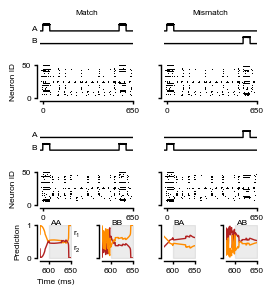

In [94]:
# Plot DMS task

offset = dms.params["stim_onset"][0]*dt

ramp_up = 0#dms.params["stim_onset"][0] * dt
print(f"Ramp up time in simulation: {ramp_up} ms")
stim1_end = ramp_up + dms.params["stim_len"] * dt
stim2_start = stim1_end + dms.params["delay"][0] * dt
stim2_end = stim2_start + dms.params["stim_len"] * dt
response_onset = stim2_end + dms.params["response_onset"] * dt
response_end = response_onset + dms.params["response"] * dt 

plt_response_start = int((response_onset-20)//dt)

time = np.arange(-dms.params["stim_onset"][0], stim.shape[1]-dms.params["stim_onset"][0]) * dt
total_time = len(time) * dt - dms.params["stim_onset"][0] * dt
print(f"Total simulation time: {total_time} ms")

# Ramp length to cut the plot at 500 ms

plot_ramp=0
plot_ramp_ms=0
spike_thr = -50
print(f"Total plotted time: {len(time) * dt} ms")


def round_string(f):
    return [f"{x:.2f}" for x in f]

stim_order = [0, 1,3,2]
response_order = [0,3,2,1]
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig = plt.figure(figsize=(2.8, 3.2))
    pad = .07
    gs = fig.add_gridspec(5, 4,hspace=.6,wspace=1)


    # Stimuli plots
    ax11 = fig.add_subplot(gs[0, :2])
    ax12 = fig.add_subplot(gs[0, 2:])

    # Individual units plots
    ax21 = fig.add_subplot(gs[1, :2])
    ax22 = fig.add_subplot(gs[1, 2:])
    ax31 = fig.add_subplot(gs[2, :2])
    ax32 = fig.add_subplot(gs[2, 2:])
    ax41 = fig.add_subplot(gs[3, :2])
    ax42 = fig.add_subplot(gs[3, 2:])
    # Readout plots
    ax51 = fig.add_subplot(gs[4, 0])
    ax52 = fig.add_subplot(gs[4, 1])
    ax53 = fig.add_subplot(gs[4, 2])
    ax54 = fig.add_subplot(gs[4, 3])

    colors = ["firebrick", "darkorange"]#papercols["jaxley"]]

    # Plot the stimulus at the top of each
    for i, ax in enumerate((ax11, ax12)):
        ax.plot(time, stim[stim_order[i]][plot_ramp:, 0] + 2, color="k")
        ax.plot(time, stim[stim_order[i]][plot_ramp:, 1], color="k")
    for i, ax in enumerate((ax31, ax32)):
        ax.plot(time, stim[stim_order[i+2]][plot_ramp:, 0] + 2, color="k")
        ax.plot(time, stim[stim_order[i+2]][plot_ramp:, 1], color="k")

    # Plot rasters
    v = solns[stim_order[0]]
    v_indiv = v[:-RNN_params["n_out"], plot_ramp:]
    raster = (v_indiv > spike_thr ).astype(int)
    #raster, sort_order = fft_max_sort(raster)
    ax21.imshow(raster, aspect="auto", cmap="binary",interpolation='none')
    
    v = solns[stim_order[1]]
    v_indiv = v[:-RNN_params["n_out"], plot_ramp:]
    raster = (v_indiv > spike_thr ).astype(int)
    ax22.imshow(raster, aspect="auto", cmap="binary")
    
    v = solns[stim_order[2]]
    v_indiv = v[:-RNN_params["n_out"], plot_ramp:]
    raster = (v_indiv > spike_thr ).astype(int)
    ax41.imshow(raster, aspect="auto", cmap="binary") 
    
    v = solns[stim_order[3]]
    v_indiv = v[:-RNN_params["n_out"], plot_ramp:]
    raster = (v_indiv > spike_thr ).astype(int)
    ax42.imshow(raster, aspect="auto", cmap="binary")

    # outputs
    out = softmax(predictions[response_order[0]].T).T
    ax51.plot(time[plt_response_start:], out[-1, plt_response_start:], color=colors[1], label=r"$r_1$")#, label=r"$match$")
    ax51.plot(time[plt_response_start:], out[-2, plt_response_start:], color=colors[0], label=r"$r_2$")# label=r"$mis-$""\n""$match$")
    out = softmax(predictions[response_order[1]].T).T
    ax52.plot(time[plt_response_start:], out[-2, plt_response_start:], color=colors[0], label=r"$r_1$")
    ax52.plot(time[plt_response_start:], out[-1, plt_response_start:], color=colors[1], label=r"$r_2$")

    out = softmax(predictions[response_order[2]].T).T
    ax53.plot(time[plt_response_start:], out[-2, plt_response_start:], color=colors[0], label=r"$r_1$")
    ax53.plot(time[plt_response_start:], out[-1, plt_response_start:], color=colors[1], label=r"$r_2$")
    out = softmax(predictions[response_order[3]].T).T
    ax54.plot(time[plt_response_start:], out[-2, plt_response_start:], color=colors[0], label=r"$r_1$")
    ax54.plot(time[plt_response_start:], out[-1, plt_response_start:], color=colors[1], label=r"$r_2$")
    
    # Fill in the response period on the readout plot
    ymin = 0
    ymax = 1
    for ax in (ax51, ax52, ax53, ax54):
        ax.fill_between(
            x=[response_onset, response_end],
            y1=ymin,
            y2=ymax,
            alpha=0.15,
            color="grey",
        )   

    # y-axis labels
    ax21.set_ylabel("Neuron ID", multialignment="center")
    ax41.set_ylabel("Neuron ID", multialignment="center")
    ax51.set_ylabel("Prediction")

    
    # y-axis ticks
    for ax in (ax11, ax12,ax31,ax32):#, ax3, ax4):
       ax.set_yticks([])
    for ax in (ax21, ax22,ax41,ax42):#, ax7, ax8):
        ax.set_yticks([0, RNN_params["n_rec"]], [RNN_params["n_rec"], 0])
    ax11.set_yticks([0.5,2.5],["B","A"])
    ax31.set_yticks([0.5,2.5],["B","A"])
    ax11.tick_params(direction='out', length=0, width=0, colors='k',
               grid_color='r', grid_alpha=0.5)
    ax31.tick_params(direction='out', length=0, width=0, colors='k',
               grid_color='r', grid_alpha=0.5)
    
    # y-axis limits
    for ax in (ax11, ax12,ax31,ax32):#, ax3, ax4):
        ax.set_ylim((-0.25, 5.0))
    for ax in (ax51, ax52, ax53, ax54):
        ax.set_ylim((0, 1))
        ax.set_yticks([0, 1], [0, 1])
   

    # x-axis ticks
    max_time = total_time#-.5
    for ax in (ax11, ax12,ax31,ax32):#, ax3, ax4):
        ax.set_xticks([])
    for ax in (ax21,ax22,ax41, ax42):
        ax.set_xticks([offset/dt, (offset+max_time)/dt], [0, "{:.0f}".format(max_time)])

    # response
    for ax in (ax51, ax52, ax53, ax54):
        ax.set_xticks([int(response_onset)+1, int(total_time)])
        ax.set_xlim(plt_response_start*dt, total_time)
        ax.set_ylim(-.01,1.01)
    # stim
    for ax in (ax11, ax12,ax31,ax32):#, ax3, ax4):
        sns.despine(ax=ax, bottom=True, left=True)
        ax.set_xlim(-offset, max_time)

    # spike raster
    for ax in (ax21,ax22,ax41,ax42):
        sns.despine(ax=ax, offset=2)
        ax.set_xlim(0,int((offset+ max_time)/dt))

    for ax in (ax51,ax52,ax53,ax54):
        sns.despine(ax=ax, offset=2)


    # Titles
    titles = ["Match", "Mismatch"]
    for i, ax in enumerate((ax11, ax12)):
        ax.set_title(titles[i], y=1.0, pad=-2)
              
    titles = ["AA", "BB", "BA", "AB"]#, "Mismatch (BA)", "Mismatch (AB)"]
    for i, ax in enumerate((ax51, ax52,ax53,ax54)):#, ax3, ax4)):
        ax.set_title(titles[i], y=1.0, pad=0.1)    
   
    #get rid of additional ticklabels
    for ax in (ax12,ax22,ax32,ax52,ax42,ax53,ax54):
        ax.set_yticklabels([])

    ax51.set_xlabel("Time (ms)")

    l = ax51.legend(bbox_to_anchor=(.6,1.1), loc='upper left',handlelength=0,fontsize=6)
    plt.savefig("../figures/dms_results.svg")#, dpi=300)
    plt.show()

    

### Supplementary Figure on dynamics

In [13]:
# Some functions to record all dynamic variables

excludes = ['CaCon_e',"eCa"]

def make_trainable(network, state_keys, verbose=True):
    network.delete_trainables()
    network.delete_recordings()
    for key in state_keys:
        if verbose:
            print(key)
        # channels
        for i in range(3):
            # check if key exists and compartment uses this key
            if key in network.cell[i].show() and ~np.isnan(network.cell[i].show()[key].iloc[0]) and key not in excludes:
                network.cell[i].make_trainable(key, verbose=verbose)
                network.cell[i].record(key, verbose=verbose)
        # synapses
        if key in network.IonotropicSynapse("all").show():
            network.IonotropicSynapse("all").make_trainable(key, verbose=verbose)
            network.IonotropicSynapse("all").record(key)

    return 

def record_all_states(network, state_keys, verbose=True):
    network.delete_recordings()
    for key in state_keys:
        if verbose:
            print(key)
        # channels
        for i in range(3):
            # check if key exsits and compartment uses this key
            if key in network.cell[i].show() and ~np.isnan(network.cell[i].show()[key].iloc[0]) and key not in excludes:
                network.cell[i].record(key, verbose=verbose)
        # synapses
        if key in network.IonotropicSynapse("all").show():
            network.IonotropicSynapse("all").record(key)

    return 


# Run extra simulations for PC plot
def simulate_repeats(opt_params, stim, n_repeats = 1, noise_init_scale =0):
    params = tf.forward(opt_params)
    input_weights = params[0]["input_weights"]

    data_stimuli = None
    for i, w in zip(range(RNN_params['n_rec']), input_weights):
        data_stimuli= network.cell(i).data_stimulate(
            jnp.inner(stim,w), data_stimuli=data_stimuli
        )
    num_timesteps = stim.shape[0]
    checkpoints = [int(np.ceil(num_timesteps ** (1/levels))) for _ in range(levels)]
    v, states = jx.integrate(
        network,
        delta_t=dt,
        data_stimuli=data_stimuli,
        solver="bwd_euler",
        checkpoint_lengths=checkpoints,
        return_states=True,
    )
    states['v']+=np.random.normal(0,1,states['v'].shape)* noise_init_scale
    for i in range(1,n_repeats):
        v, states = jx.integrate(
        network,
        delta_t=dt,
        t_max = len(stim)*dt,
        solver="bwd_euler",
        checkpoint_lengths=checkpoints,
        return_states=True,
        all_states = states,
    )
    return v

In [14]:
# Record all states

_, states = jx.integrate(network, return_states=True, t_max=0)
network.delete_trainables()

record_all_states(network, states,verbose=True)
make_trainable(network, states,verbose=True)

CaCon_e
CaCon_i
Added 50 recordings. See `.recordings` for details.
CaHVA_h
Added 50 recordings. See `.recordings` for details.
CaHVA_m
Added 50 recordings. See `.recordings` for details.
CaLVA_h
Added 50 recordings. See `.recordings` for details.
CaLVA_m
Added 50 recordings. See `.recordings` for details.
H_m
Added 52 recordings. See `.recordings` for details.
Added 50 recordings. See `.recordings` for details.
IonotropicSynapse_current
IonotropicSynapse_s
Added 229 recordings. See `.recordings` for details.
M_m
Added 52 recordings. See `.recordings` for details.
NaTs2T_h
Added 52 recordings. See `.recordings` for details.
Added 50 recordings. See `.recordings` for details.
NaTs2T_m
Added 52 recordings. See `.recordings` for details.
Added 50 recordings. See `.recordings` for details.
SKE2_z
Added 50 recordings. See `.recordings` for details.
SKv3_1_m
Added 52 recordings. See `.recordings` for details.
Added 50 recordings. See `.recordings` for details.
eCa
iLeak
i_Ca
i_H
i_K
i_Na
v
A

In [70]:
(int(1000/dt))

40000

In [71]:
# Run simulations with and without stimuli

#get long term dynamics / attractor
v = simulate_repeats(opt_params,np.zeros(((int(1000/dt)),2)),n_repeats=10,noise_init_scale=0)#[:,50000:]
v = np.nan_to_num(v,nan=0)

# Make stimuli
stim1 = np.zeros((int(1000/dt),2))
stim1[int(20/dt):int(70/dt),0]=1
stim2 = np.zeros((int(1000/dt),2))
stim2[int(20/dt):int(70/dt),1]=1

v1 = simulate_repeats(opt_params, stim=stim1)[:,:]#[nan_inds]#,5000:-5000]
v2 = simulate_repeats(opt_params, stim=stim2)[:,:]#[nan_inds]#,5000:-5000]
v1 = np.nan_to_num(v1,nan=0)
v2 = np.nan_to_num(v2,nan=0)


In [72]:
# Get parameter labels and indices
param_dict = network.get_parameters()
n_params = network.num_trainable_params
param_keys = [list(param.keys())[0] for param in param_dict]
n_per_key = [len(list(param.values())[0].flatten()) for param in param_dict]
inds = np.cumsum(n_per_key)

In [73]:
# normalisation functions

def mean_std_by_key(v,inds):
    means = []
    stds = []
    for i,ind in enumerate(inds):
        if i == 0:
            means.append(np.mean(v[:ind]))
            stds.append(np.std(v[:ind]))
        else:
            means.append(np.mean(v[inds[i-1]:ind]))
            stds.append(np.std(v[inds[i-1]:ind]))
    return means,stds


def norm_by_key(v,inds,means,stds):
    v_norm = []
    for i,ind in enumerate(inds):
        if i == 0:
            v_norm.append((v[:ind]-means[i])/stds[i])
        else:
            v_norm.append((v[inds[i-1]:ind]-means[i])/stds[i])
    return np.concatenate(v_norm)




In [74]:
# smooth, normalise and plot in PC space

# Smooth
window_l=1000
window = signal.windows.hann(window_l)
v1z= ndimage.convolve1d(v1, window,axis=1)
v2z= ndimage.convolve1d(v2, window,axis=1)
vz= ndimage.convolve1d(v, window,axis=1)

# Normalise
pc_trace = np.concatenate([v1z.T,v2z.T,vz.T]).T
pc_trace -=np.mean(pc_trace,axis=1)[:,None]
means,stds = mean_std_by_key(pc_trace,inds)
pc_trace = norm_by_key(pc_trace,inds,means,stds)

# PCA
n_comp = 3
pca = PCA(n_components=n_comp)
pca.fit(pc_trace.T)
zpc = pca.transform(pc_trace.T)



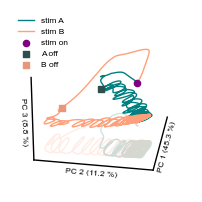

In [95]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    pc2 = 1
    t1 = int(20/dt)+1
    t2 = int(70/dt)+501
    t3 = int(500/dt)+1
    t0 = 300

    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(zpc[t0:40001,0],zpc[t0:40001,1],zpc[t0:40001,2],color='teal',label= 'stim A')
    ax.plot(zpc[40001+t0:80002,0],zpc[40001+t0:80002,1],zpc[40001+t0:80002,2],color='lightsalmon',label='stim B')

    floor=-30
    ax.plot(zpc[:40001,0],zpc[:40001,1],np.ones_like(zpc[:40001,2])*floor, color ='teal',zorder=-10,alpha=.2)
    ax.plot(zpc[40001:80002,0],zpc[40001:80002,1],np.ones_like(zpc[40001:80002,2])*floor, color ='lightsalmon',zorder=-10,alpha=.2)


    ax.scatter(zpc[ t0,0],zpc[ t0,1],zpc[ t0,2],color='purple',zorder=10,label='stim on')#_#,marker='s')
    ax.scatter(zpc[t2,0],zpc[t2,1],zpc[t2,2],color='darkslategrey',zorder=10,marker='s',label='A off')
    ax.scatter(zpc[t2+40000,0],zpc[t2+40000,1],zpc[t2+40000,2],color='darksalmon',zorder=11,alpha=1,marker='s',label='B off')
    plt.legend()
    
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel("PC 1 ({:.1f} %)".format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel("PC 2 ({:.1f} %)".format(pca.explained_variance_ratio_[1]*100))
    ax.set_zlabel("PC 3 ({:.1f} %)".format(pca.explained_variance_ratio_[2]*100), rotation=90)
    ax.zaxis.labelpad=-17 
    ax.xaxis.labelpad=-17 
    ax.yaxis.labelpad=-17 
    ax.view_init(25,190,0)

    plt.tight_layout()
    plt.savefig("../figures/pca.png")
    plt.show()